In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

In [3]:
dataset_dir= r"D:\Project1\Garbage\archive\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [6]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [7]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


### Visualise sample images from each class.

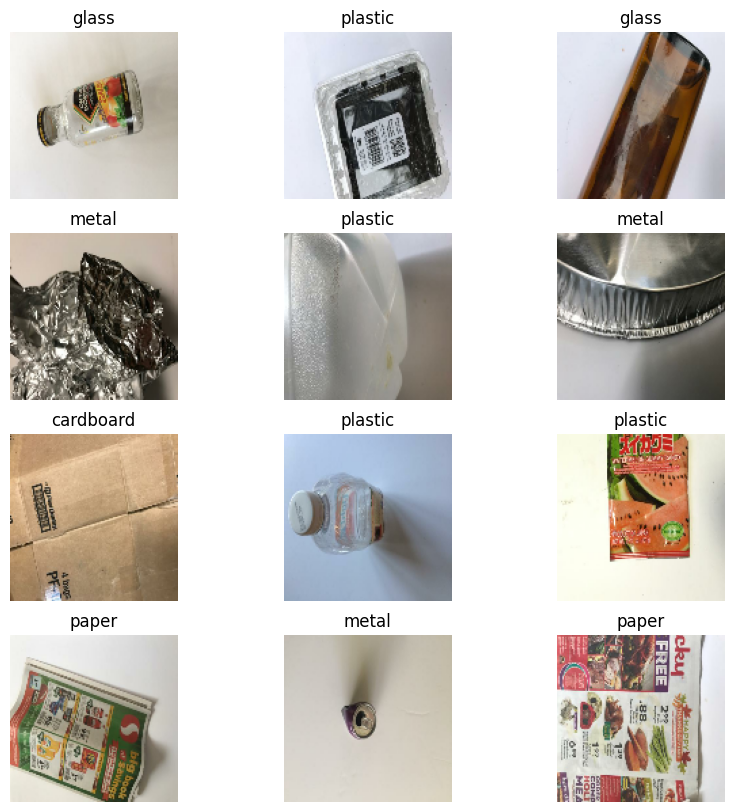

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

- ## Checking the number of images per class to ensure balance
- ## Understanding image properties like image dimensions, class labels

In [9]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [10]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [11]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


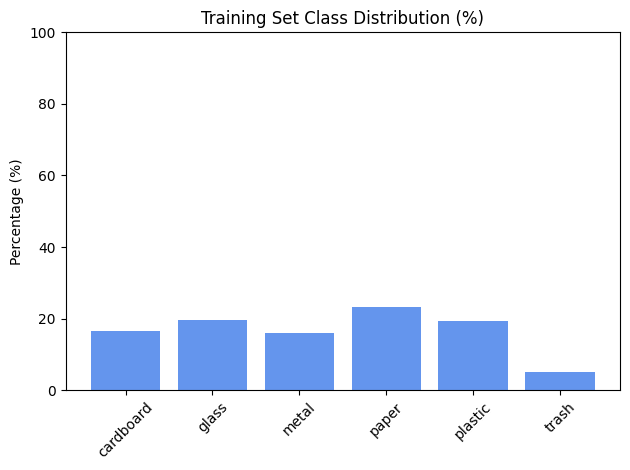

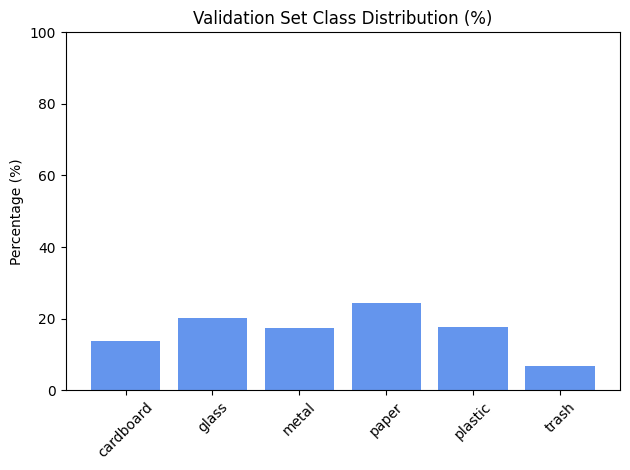

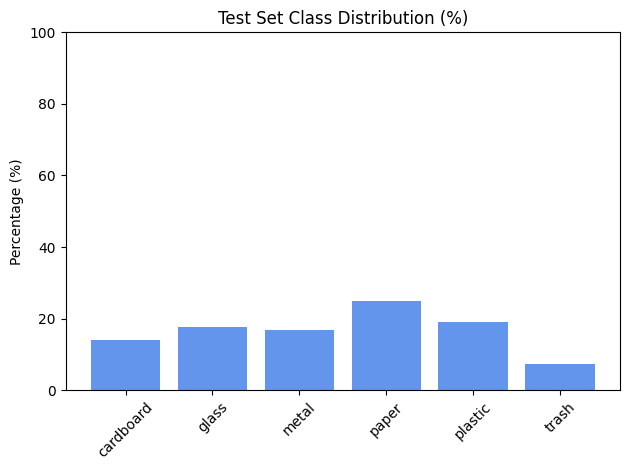

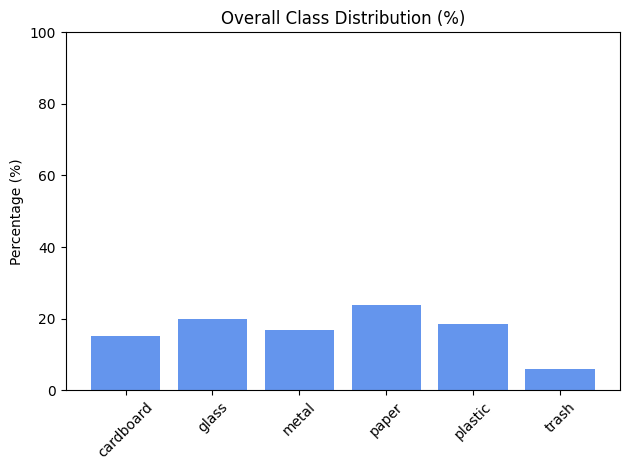

In [12]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

# interence on Class Imbalance

The **"Garbage Image Dataset"** reveals a noticeable **imbalance** in the distribution of its image categories:

| Category     | Image Count | Updated Distribution |
|--------------|-------------|----------------|
| Cardboard | 403          | 15.09           |
|  Glass     | 501         | 19.96           |
|  Metal     | 410         | 16.68           |
|  Paper     | 594         | 23.82          |
|  Plastic   | 482         | 18.53         |
|  Trash     | 137         |  5.91          |

### Addressing Imbalance Using Class Weights:

$$
\text{weight(class)} = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}}
$$

These computed weights are then passed to the model.

In [22]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [23]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}



## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

In [24]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B2`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

In [25]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step



## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`, 
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

### Model Architecture and Layer Utilities

- **Sequential**: A simple way to build models by stacking layers one after the other in a linear fashion.

- **RandomFlip**: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

- **RandomRotation**: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

- **RandomZoom**: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

- **Dropout**: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

- **GlobalAveragePooling2D**: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

- **Dense**: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

- **Input**: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

- **EfficientNetV2B2**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.


In [26]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [27]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 🔁 Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving

In [28]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

In [29]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 888ms/step - accuracy: 0.3004 - loss: 1.6792 - val_accuracy: 0.6099 - val_loss: 1.1838
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6640 - loss: 1.0578 - val_accuracy: 0.7723 - val_loss: 0.7881
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7589 - loss: 0.7405 - val_accuracy: 0.8376 - val_loss: 0.5776
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 897ms/step - accuracy: 0.8383 - loss: 0.5111 - val_accuracy: 0.8792 - val_loss: 0.4214
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8780 - loss: 0.3838 - val_accuracy: 0.8792 - val_loss: 0.3589
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9105 - loss: 0.2967 - val_accuracy: 0.8832 - val_loss: 0.3379
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 959ms/step - accuracy: 0.9282 - loss: 0.2339 - val_accuracy: 0.8911 - val_loss: 0.3031
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 992ms/step - accuracy: 0.9402 - loss: 0.1811 - val_accuracy: 0.8911

In [30]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [31]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

# Model Performance Visualization: Accuracy & Loss Trends

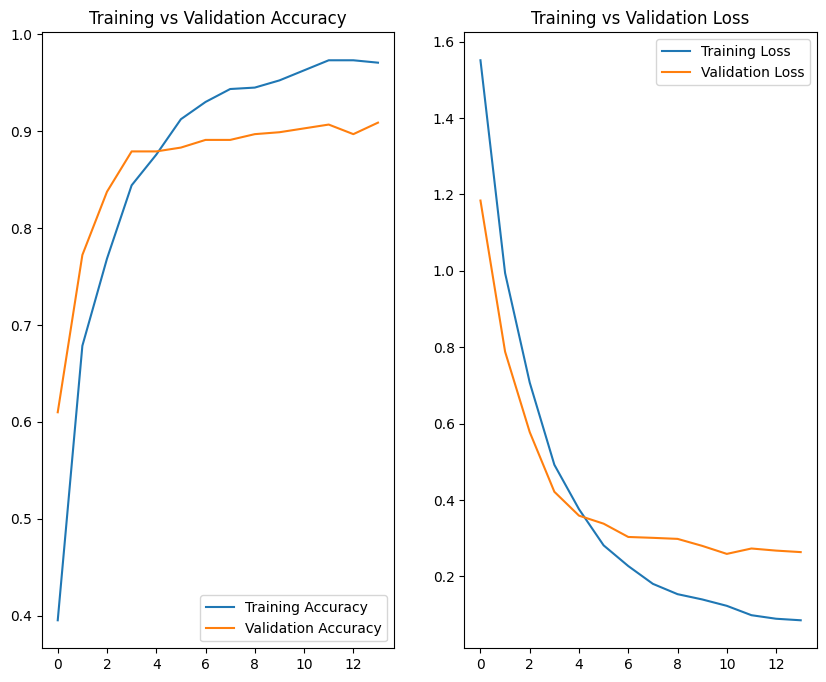

In [32]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

## 5.  Model Evaluation
- Plot training and validation accuracy/loss curves.
- Evaluate model performance on validation or test set.
- Use metrics like:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score)
  - `confusion_matrix`, `classification_report`: To evaluate the model's classification performance.

In [33]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.9290 - loss: 0.2036
Test accuracy is0.9180, Test loss is 0.2273


In [34]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step
[[28  0  0  2  0  0]
 [ 0 41  4  0  2  0]
 [ 0  1 47  0  1  1]
 [ 0  0  2 59  1  0]
 [ 0  1  0  0 40  4]
 [ 0  0  1  1  0 20]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.95      0.87      0.91        47
           2       0.87      0.94      0.90        50
           3       0.95      0.95      0.95        62
           4       0.91      0.89      0.90        45
           5       0.80      0.91      0.85        22

    accuracy                           0.92       256
   macro avg       0.91      0.92      0.91       256
weighted avg       0.92      0.92      0.92       256



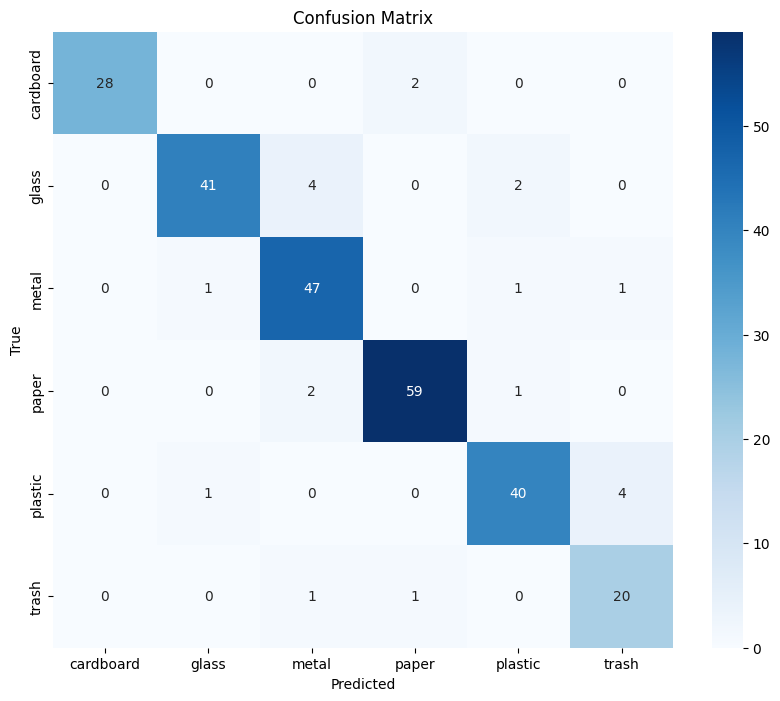

In [35]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

## 7.  Final Testing and Save the Model
- Evaluate the final model on the unseen **test dataset**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


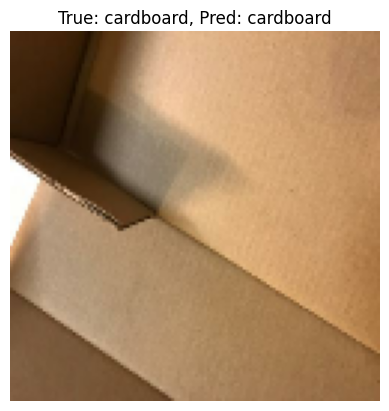

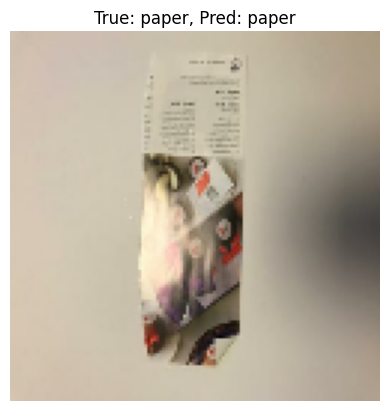

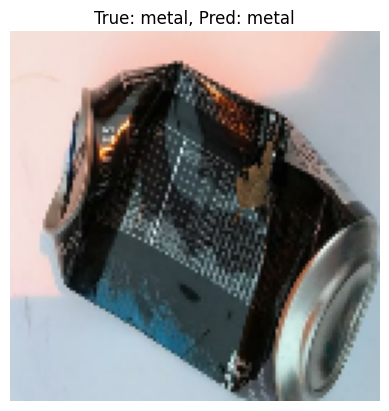

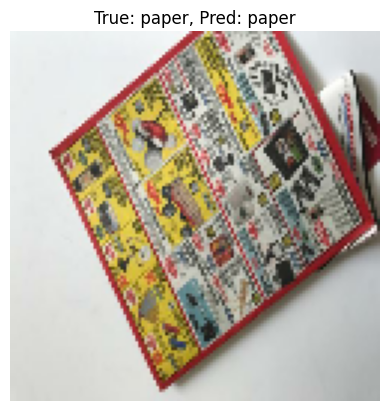

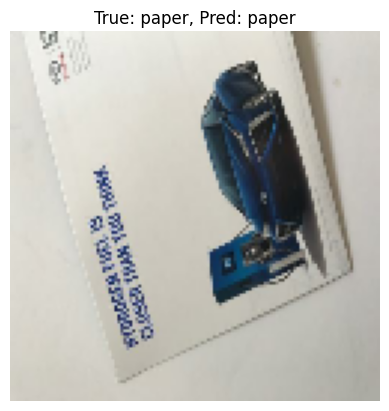

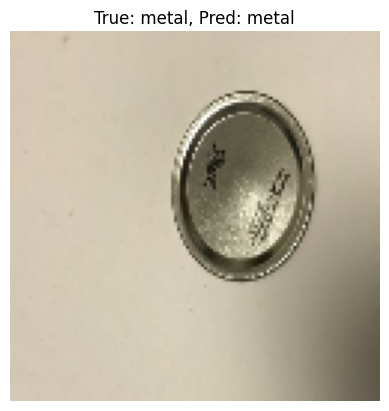

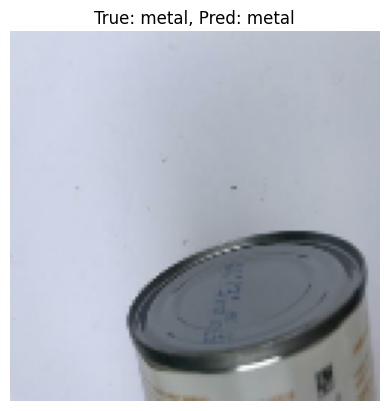

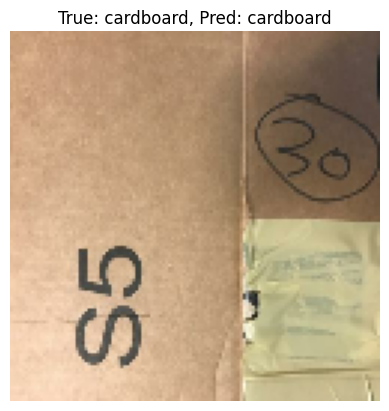

In [36]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [37]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')